In [1]:
import pandas as pd
import numpy as np
import time
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from backtest_functions_v2 import *

In [2]:
df = pd.read_parquet("../data/full_dataset_feature_engineering_v2.parquet")

### Spliting dataset

In [3]:
# list of features column names
all_features = df.columns.drop(['target', 'return_forward'])

In [4]:
df_train = df[df['year'].isin([2021, 2022, 2023])]
df_test = df[df['year'] == 2024]

X_train = df_train[all_features]
y_train = df_train['target']
X_test = df_test[all_features]
y_test = df_test['target']

# Print class distribution
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Test set class distribution: {np.bincount(y_test)}")

Training set class distribution: [ 9993  6038 10243]
Test set class distribution: [2648 3274 2862]


### Logistic regression

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(
        penalty='l1',         # L1 regularization for feature selection
        solver='saga',       # Optimizer for L1 regularization
        max_iter=8000,
        random_state=42,
        class_weight='balanced'  # Handle class imbalance if exists
    ))
])

param_grid = {
    # 'model__C': np.logspace(-2, 4, 20)
    'model__C': [0.01, 0.1, 1, 10, 100] # regularization parameter C
}

# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

# Grid search with time series validation
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=tscv,
    scoring='roc_auc', # for class imbalance
    n_jobs=-1,
    verbose=1
)

# Fit model
grid_search.fit(X_train, y_train)

# Get the best model from cross-validation
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [ ]:
# Evaluate on test set
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

In [ ]:
# Performance metrics
print(f"Best Parameters: {grid_search.best_params_}")
print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Get the full probability matrix for multi-class ROC AUC
y_proba_full = best_model.predict_proba(X_test)
print(f"Test ROC AUC: {roc_auc_score(y_test, y_proba_full, multi_class='ovr'):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Best Parameters: {'model__C': 0.01}

Test Accuracy: 0.4945
Test ROC AUC: 0.7007

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.35      0.38      2648
           1       0.55      0.75      0.63      3274
           2       0.46      0.34      0.39      2862

    accuracy                           0.49      8784
   macro avg       0.48      0.48      0.47      8784
weighted avg       0.48      0.49      0.48      8784



Shape of coefficient matrix: (3, 139)

Top 15 most important features for Bearish (0):
                           Feature  Coefficient  Abs_Coefficient
61                        pct_b_10     0.073389         0.073389
66          tanalysis_absa_ewm_70h    -0.052713         0.052713
130        NER_microstrategy_last3    -0.020882         0.020882
124                  NER_fed_last3     0.018243         0.018243
47             norm_price_change_7     0.016818         0.016818
95      source_Cryptopolitan_last3     0.015493         0.015493
21                  macd_histogram    -0.012142         0.012142
116              NER_binance_last3     0.010944         0.010944
11         sma_50_200_diff_abs_chg     0.010379         0.010379
114             topic_others_last3    -0.009446         0.009446
129      NER_michael saylor_last24     0.008652         0.008652
81            source_Bitcoin_last3     0.008038         0.008038
83   source_Bitcoin Magazine_last3     0.007868         0.007868
97 

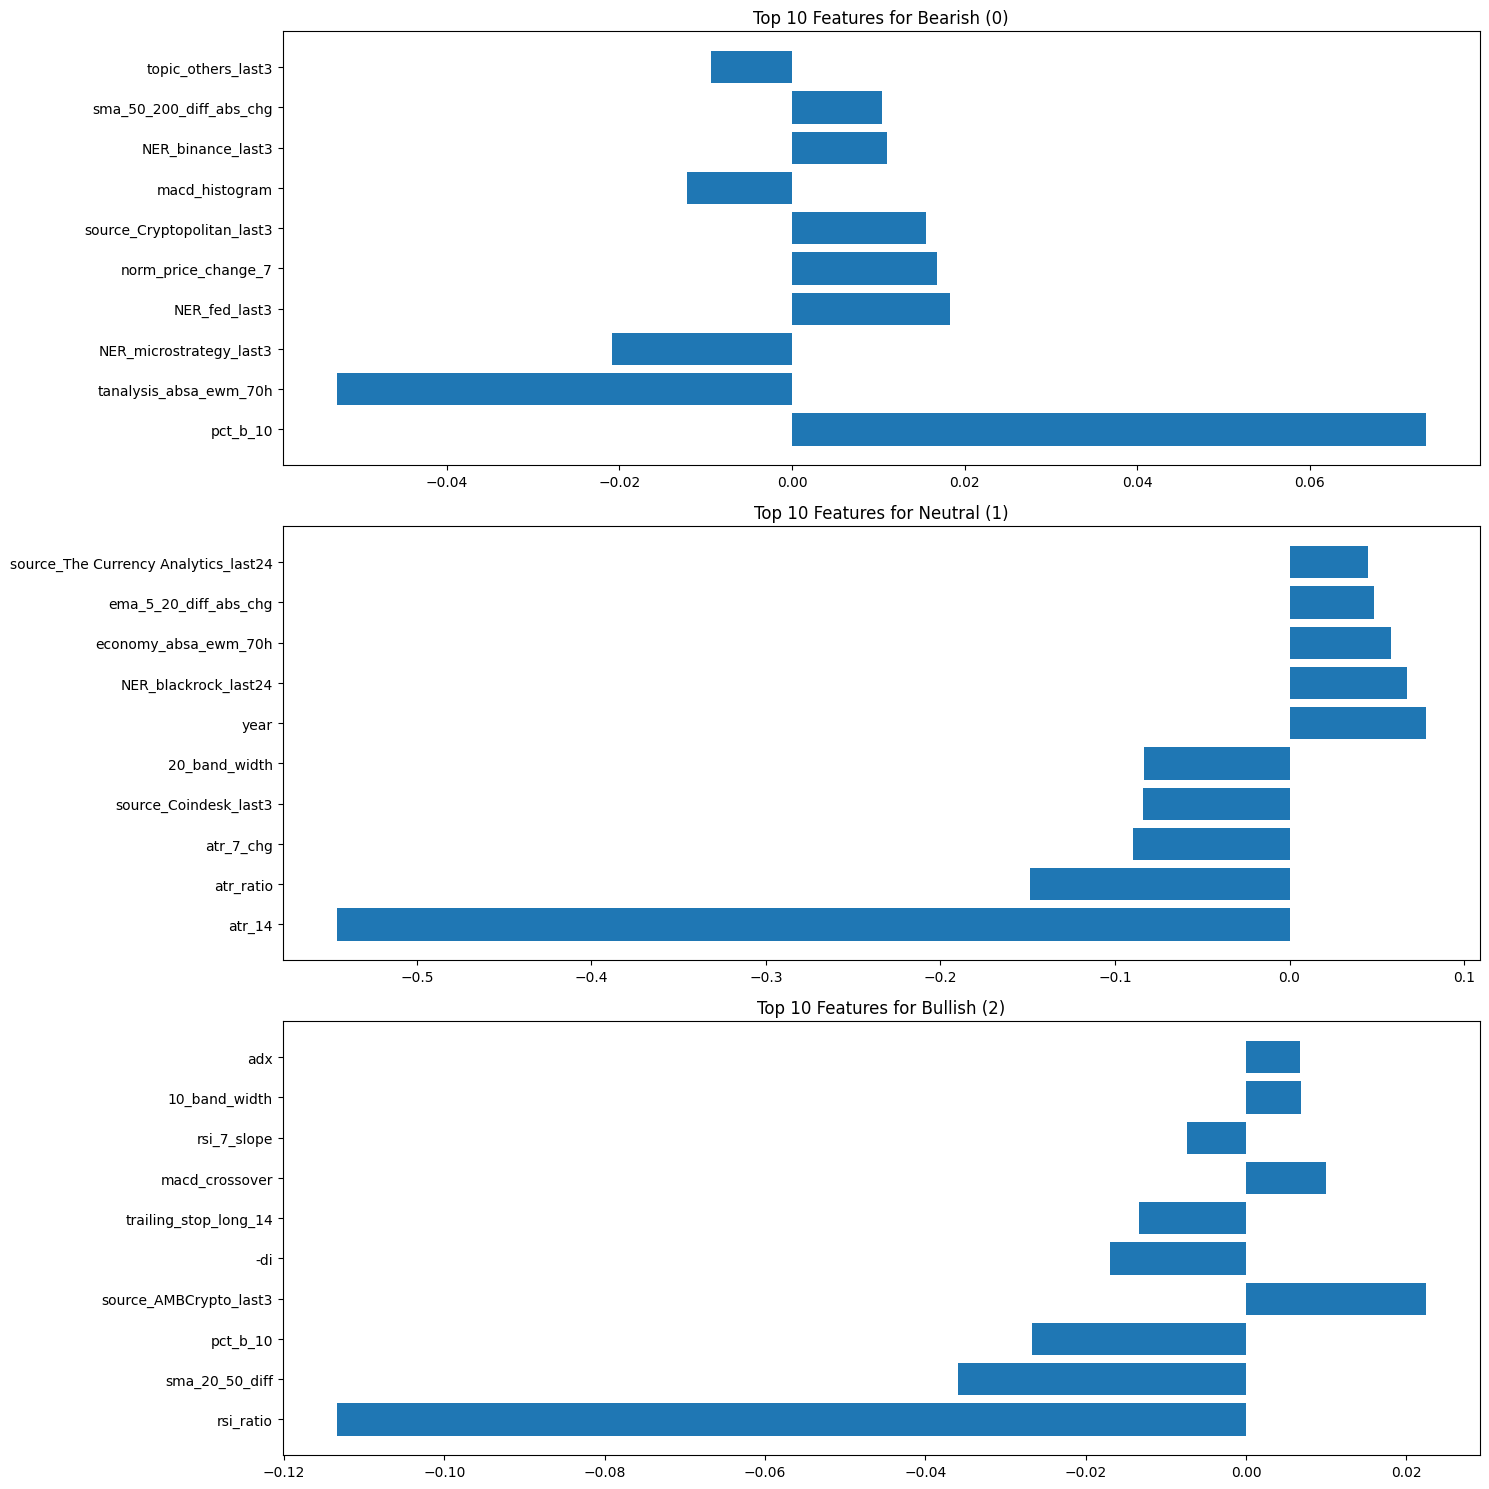


Number of features used by the model (non-zero coefficients): 73
Total number of features: 417
Feature utilization: 17.51%


In [ ]:
# Get the coefficients from the model
model = best_model.named_steps['model']
coefficients = model.coef_

# Print the shape of coefficients to understand the structure
print(f"Shape of coefficient matrix: {coefficients.shape}")

# Get feature names
feature_names = X_train.columns

# Create a function to display coefficients for a class
def display_class_coefficients(class_idx, class_name):
  # For multi-class, coefficients has shape (n_classes, n_features)
  class_coefs = coefficients[class_idx]
  
  # Create a DataFrame
  coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': class_coefs
  })
  
  # Sort by absolute coefficient value
  coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
  coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)
  
  # Display top features
  print(f"\nTop 15 most important features for {class_name}:")
  print(coef_df.head(15))
  
  return coef_df

# Display coefficients for each class
class_names = ['Bearish (0)', 'Neutral (1)', 'Bullish (2)']

plt.figure(figsize=(15, 15))

for i, class_name in enumerate(class_names):
  coef_df = display_class_coefficients(i, class_name)
  
  # Plot
  plt.subplot(3, 1, i+1)
  plt.barh(coef_df.head(10)['Feature'], coef_df.head(10)['Coefficient'])
  plt.title(f'Top 10 Features for {class_name}')

plt.tight_layout()
plt.show()

# Count number of non-zero coefficients
non_zero_coef = (np.abs(coefficients) > 1e-5).sum()
print(f"\nNumber of features used by the model (non-zero coefficients): {non_zero_coef}")
print(f"Total number of features: {len(feature_names) * 3}")
print(f"Feature utilization: {non_zero_coef/(len(feature_names) * 3)*100:.2f}%")

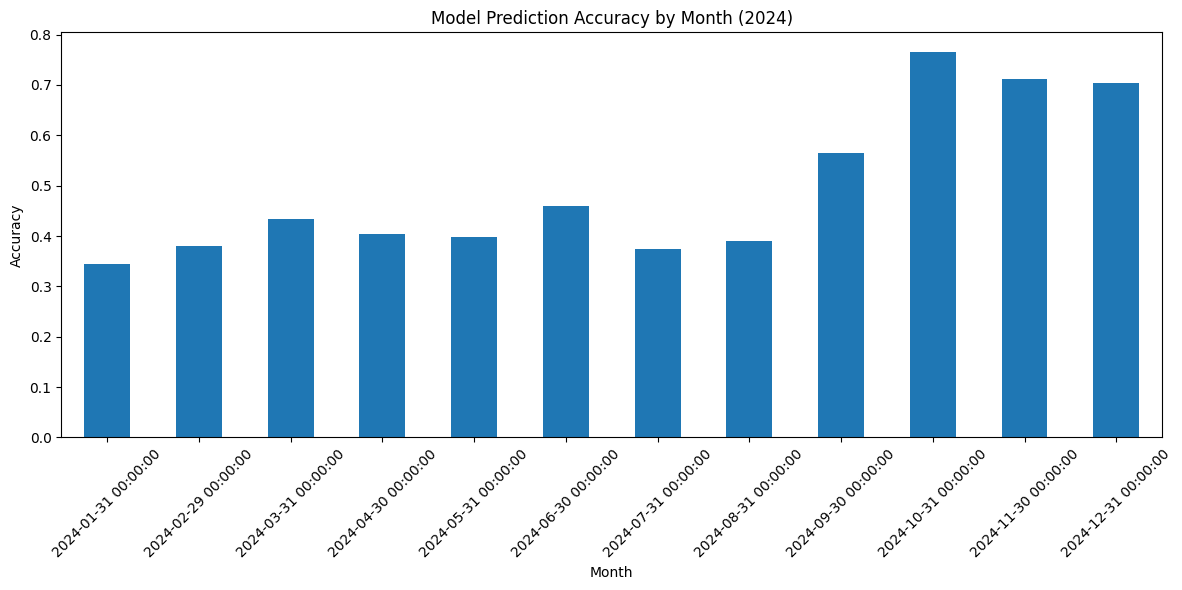

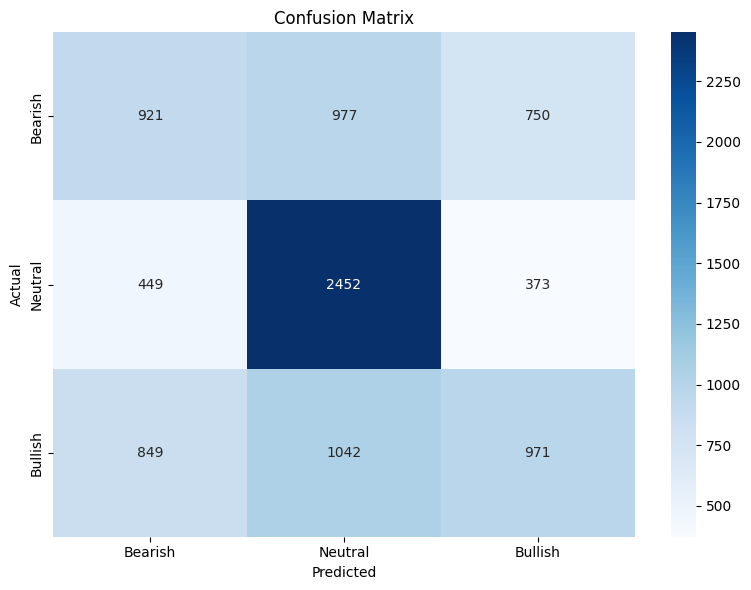

In [ ]:
# Add predictions and probabilities to test dataframe
df_test.loc[:, 'predicted_class'] = y_pred
df_test.loc[:, 'prob_bearish'] = y_proba_full[:, 0]
df_test.loc[:, 'prob_neutral'] = y_proba_full[:, 1]
df_test.loc[:, 'prob_bullish'] = y_proba_full[:, 2]

# Define the mapping from numerical target to labels
target_map = {0: 'Bearish', 1: 'Neutral', 2: 'Bullish'}

# Map target values to more descriptive labels
df_test.loc[:, 'actual_label'] = df_test['target'].map(target_map)
df_test.loc[:, 'predicted_label'] = df_test['predicted_class'].map(target_map)

# Calculate whether the prediction was correct
df_test.loc[:, 'correct_prediction'] = (df_test['target'] == df_test['predicted_class']).astype(int)

# Calculate monthly accuracy
monthly_accuracy = df_test.resample('ME')['correct_prediction'].mean()

# Plot monthly accuracy
plt.figure(figsize=(12, 6))
monthly_accuracy.plot(kind='bar')
plt.title('Model Prediction Accuracy by Month (2024)')
plt.ylabel('Accuracy')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show confusion matrix
conf_matrix = confusion_matrix(df_test['target'], df_test['predicted_class'])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
      xticklabels=['Bearish', 'Neutral', 'Bullish'],
      yticklabels=['Bearish', 'Neutral', 'Bullish'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

### Backtest

In [ ]:
df_test.head()

,news_count,return_forward,sma_5_20_diff,sma_20_50_diff,sma_50_200_diff,ema_5_20_diff,ema_20_50_diff,ema_50_200_diff,sma_5_20_diff_abs_chg,sma_5_20_diff_pct_chg,...,reddit_total_sentiment_ewm_24h,reddit_average_sentiment_ewm_5h,reddit_average_sentiment_ewm_24h,predicted_class,prob_bearish,prob_neutral,prob_bullish,actual_label,predicted_label,correct_prediction
2024-01-01 00:00:00,0.0,-0.001385,143.55,210.51,-647.125,123.182375,73.241757,-290.164294,-3.40,-0.023137,...,0.097778,0.003539,0.010173,1,0.209071,0.587212,0.203717,Bearish,Neutral,0
2024-01-01 01:00:00,1.0,-0.000729,151.35,210.81,-631.665,101.159360,74.849008,-282.793610,7.80,0.054336,...,0.089956,0.002359,0.009359,1,0.228097,0.554759,0.217144,Neutral,Neutral,1
2024-01-01 02:00:00,3.0,-0.005929,120.60,219.66,-617.505,77.283277,74.229918,-276.579317,-30.75,-0.203171,...,0.135111,0.028840,0.015154,1,0.231577,0.528949,0.239474,Bearish,Neutral,0
2024-01-01 03:00:00,4.0,0.000095,43.45,223.39,-605.320,0.428392,59.296872,-277.935098,-77.15,-0.639718,...,0.124302,0.019226,0.013942,1,0.233415,0.398111,0.368473,Neutral,Neutral,1
2024-01-01 04:00:00,2.0,0.005017,-37.10,221.12,-591.100,-44.989742,46.318484,-278.999237,-80.55,-1.853855,...,0.114358,0.012818,0.012827,1,0.230043,0.440861,0.329096,Bullish,Neutral,0


Overall Annual Return: 29.82%
Overall Annual Sharpe Ratio: 0.8084
Maximum Drawdown: -33.35 %
Alpha: 0.3788
Beta: 0.0422

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       0.298206    0.445988     0.042214      0.321242       0.808403


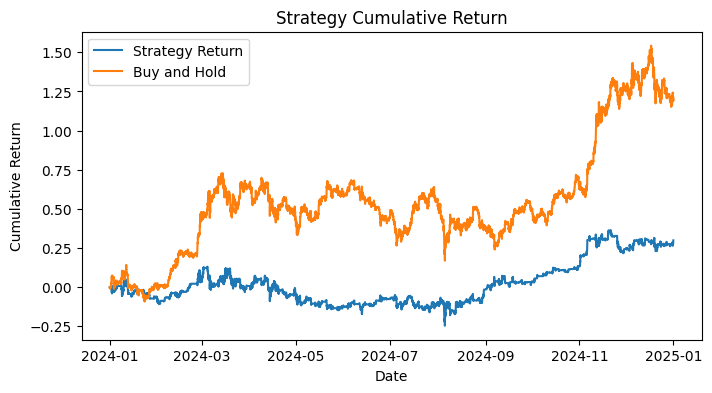

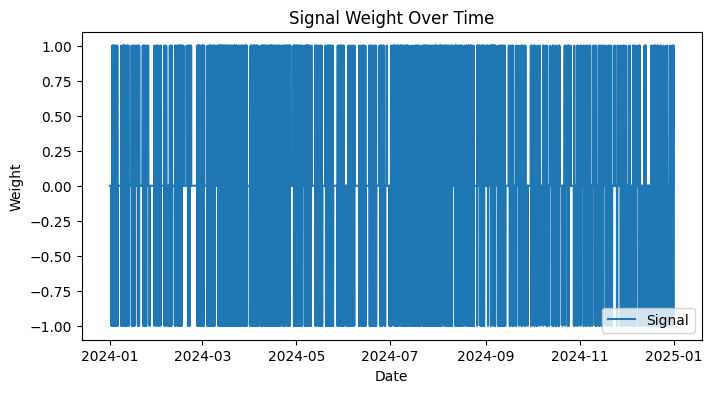

In [ ]:
df_test['signal'] = df_test['predicted_class'] - 1

run_backtest(df_test, freq='h')